In [1]:
import numpy as np
from ccfj import GetStationPairs
import os
import matplotlib.pyplot as plt
import scipy.signal as sgn
import scipy.io as scio
import h5py
import yaml

In [2]:
import sys
sys.path.append(r'../tools_F-J/')
from toollib_standard import maplib
from toollib_standard import mathlib
from toollib_standard import filelib
from toollib_standard import stacklib
from toollib_standard import plotlib

In [3]:
with open('a-project.yml', 'r', encoding='utf-8') as f:
    proj = yaml.load(f.read(), Loader=yaml.FullLoader)
name_project = proj['name']
#name_project = 'project/output_FJSJ_16-01/'               # Harmon server
name_project

'project/output_FJSJ_17-06/'

In [4]:
with open('0_config.yml', 'r', encoding='utf-8') as f:
    dir_config = yaml.load(f.read(), Loader=yaml.FullLoader)
dir_project_workspace = dir_config['dir_project_workspace']
dir_CC_workspace = dir_config['dir_CC_workspace']
print('dir_CC_workspace: ', dir_CC_workspace)
print('dir_project_workspace: ', dir_project_workspace)
dir_project = dir_project_workspace + name_project
print('dir_project: ', dir_project)

dir_CC_workspace:  /shdisk/rem2/Harmon/F-J/San/
dir_project_workspace:  /shdisk/rem2/Harmon/F-J/San/
dir_project:  /shdisk/rem2/Harmon/F-J/San/project/output_FJSJ_17-06/


In [5]:
filename = dir_project+'Basic_info.yml'
with open(filename, 'r', encoding='utf-8') as f:
    info_basic = yaml.load(f.read(), Loader=yaml.FullLoader)
filename_bi = dir_project+'Basic_info.npy'
info_basic_bi = np.load(filename_bi, allow_pickle='TRUE').item()      # setting dictionary

### Define how many subworks to be done

In [6]:
key_subworks = ['01-01']
key_subworks = info_basic['key_subworks']
key_subworks

['03-02',
 '04-02',
 '05-02',
 '06-02',
 '07-02',
 '08-02',
 '09-02',
 '10-02',
 '11-02',
 '12-02',
 '13-02',
 '14-02',
 '15-02',
 '16-02',
 '17-02',
 '18-02',
 '19-02',
 '20-02',
 '21-02',
 '22-02',
 '23-02',
 '24-02',
 '25-02',
 '26-02',
 '27-02',
 '28-02',
 '29-02',
 '30-02',
 '31-02',
 '32-02',
 '33-02',
 '34-02',
 '35-02',
 '36-02',
 '37-02',
 '38-02',
 '39-02',
 '40-02',
 '41-02',
 '42-02',
 '43-02',
 '44-02',
 '45-02',
 '46-02',
 '47-02',
 '48-02',
 '49-02',
 '50-02',
 '51-02',
 '52-02',
 '53-02',
 '54-02',
 '55-02',
 '56-02',
 '57-02',
 '58-02',
 '03-03',
 '04-03',
 '05-03',
 '06-03',
 '07-03',
 '08-03',
 '09-03',
 '10-03',
 '11-03',
 '12-03',
 '13-03',
 '14-03',
 '15-03',
 '16-03',
 '17-03',
 '18-03',
 '19-03',
 '20-03',
 '21-03',
 '22-03',
 '23-03',
 '24-03',
 '25-03',
 '26-03',
 '27-03',
 '28-03',
 '29-03',
 '30-03',
 '31-03',
 '32-03',
 '33-03',
 '34-03',
 '35-03',
 '36-03',
 '37-03',
 '38-03',
 '39-03',
 '40-03',
 '41-03',
 '42-03',
 '43-03',
 '44-03',
 '45-03',
 '46-03',


In [7]:
dir_stack = dir_project + info_basic['dir_stack']

### Plot linear summed ncfst

In [8]:
def check_timewindow(info_basic,info_basic_bi,key_subwork,v_min,v_max,tao,ax,start,interval,flag_time,flag_sig,flag_plot):
    global dir_stack
    outname = key_subwork+'_gather_linear.h5'
    ncffile = h5py.File(dir_stack + outname,'r')
    ncfs_sum_linear = ncffile['ncfs'][:]
    r0 = ncffile['r'][:]

    indx = np.argsort(r0)
    r0 = r0[indx]
    ncfs_sum_linear = ncfs_sum_linear[indx,:]
    ncfst_linear = mathlib.freq_time(ncfs_sum_linear)


    # half side
    num = int((len(ncfst_linear[0]))/2)
    ncfst_half = np.zeros([np.shape(ncfs_sum_linear)[0],num])
    for i in range(len(ncfst_half)):
        ncfst_half[i,:] = (ncfst_linear[i,0:num][::-1] + ncfst_linear[i,num::])/2
    t = info_basic_bi['t']
    f = info_basic_bi['f']
    nsta = info_basic['nstaS'][key_subwork]
    nPairs = int(nsta*(nsta-1)/2)
    sigwins0,noisewins10,noisewins20 = stacklib.cal_wins(ncfst_half,r0,t[num:],f,v_min,v_max,tao,nPairs,flag_sig)

    info_basic_bi['v_min'][key_subwork] = v_min
    info_basic_bi['v_max'][key_subwork] = v_max
    info_basic_bi['tao'][key_subwork] = tao
    #info_basic_bi['start'][key_subwork] = start
    #info_basic_bi['interval'][key_subwork] = interval
    #info_basic_bi['flag_time'][key_subwork] = flag_time
    info_basic_bi['sigwins'][key_subwork] = sigwins0
    info_basic_bi['noisewins1'][key_subwork] = noisewins10
    info_basic_bi['noisewins2'][key_subwork] = noisewins20

    # plot
    if flag_plot == 0:
        return t,ncfst_linear,info_basic_bi
    
    title0 = ' '
    #title0 = 'CCF in time domain for subwork: ' + key_subwork
    xlim = [-1,1]
    ax[0] = plotlib.plot_ncfst(ax[0],t,ncfst_linear[start::interval],r0[start::interval],title0,flag_time,xlim,0)
    ax[1] = plotlib.plot_ncfst(ax[1],t,ncfst_linear[start::interval],r0[start::interval],title0,flag_time,xlim,0)
    r = r0[start::interval]
    sigwins = sigwins0[start::interval]
    noisewins1 = noisewins10[start::interval]
    noisewins2 = noisewins20[start::interval]
    for i in range(len(r)):
        ax[1].plot(t[num+sigwins[i][0]],r[i],'r.')
        ax[1].plot(t[num+sigwins[i][1]],r[i],'r.')
        ax[1].plot(-t[num+sigwins[i][0]],r[i],'r.')
        ax[1].plot(-t[num+sigwins[i][1]],r[i],'r.')
        ax[1].hlines(r[i],t[num+sigwins[i][0]],t[num+sigwins[i][1]],'g',linestyles='--')
        ax[1].hlines(r[i],-t[num+sigwins[i][0]],-t[num+sigwins[i][1]],'g',linestyles='--')
    #title0 = 'CCF in time domain for subwork: ' + key_subwork
    #xlim = [0,300]
    #ax[1] = plotlib.plot_ncfst_timewindow(ax[1],t[num:],ncfst_half[start::interval],r0[start::interval],title0,flag_time,v,tao,xlim)
    plt.tight_layout()
    #dir_image = dir_project + info_basic['dir_image']
    #plt.savefig(dir_image+key_subwork+'_CCF-timewindow.png',dpi=60)
    #plt.savefig(dir_project+'image/CCF_timewindow_'+key_subwork+'.png',dpi=300)

    
    return t,ncfst_linear,info_basic_bi

In [9]:
info_basic_bi['v_min'] = {}
info_basic_bi['v_max'] = {}
info_basic_bi['tao'] = {}
#info_basic_bi['start'] = {}
#info_basic_bi['interval'] = {}
#info_basic_bi['flag_time'] = {}
info_basic_bi['sigwins'] = {}
info_basic_bi['noisewins1'] = {}
info_basic_bi['noisewins2'] = {}

In [10]:
flag_time = 0.008
start = 0
interval = 1
info_basic['flag_time'] = flag_time
info_basic['start'] = start
info_basic['interval'] = interval
with open(dir_project+'Basic_info.yml', 'w', encoding='utf-8') as f:
   yaml.dump(data=info_basic, stream=f, allow_unicode=True)

In [11]:
key_subworks_sample = key_subworks[0:10:5]
key_subworks_sample

['03-02', '08-02']

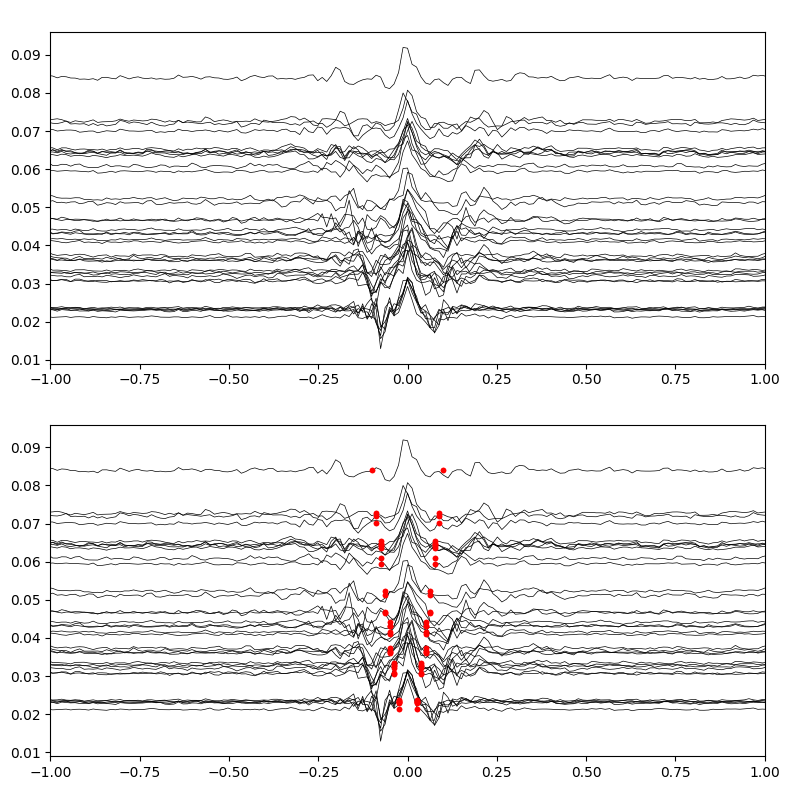

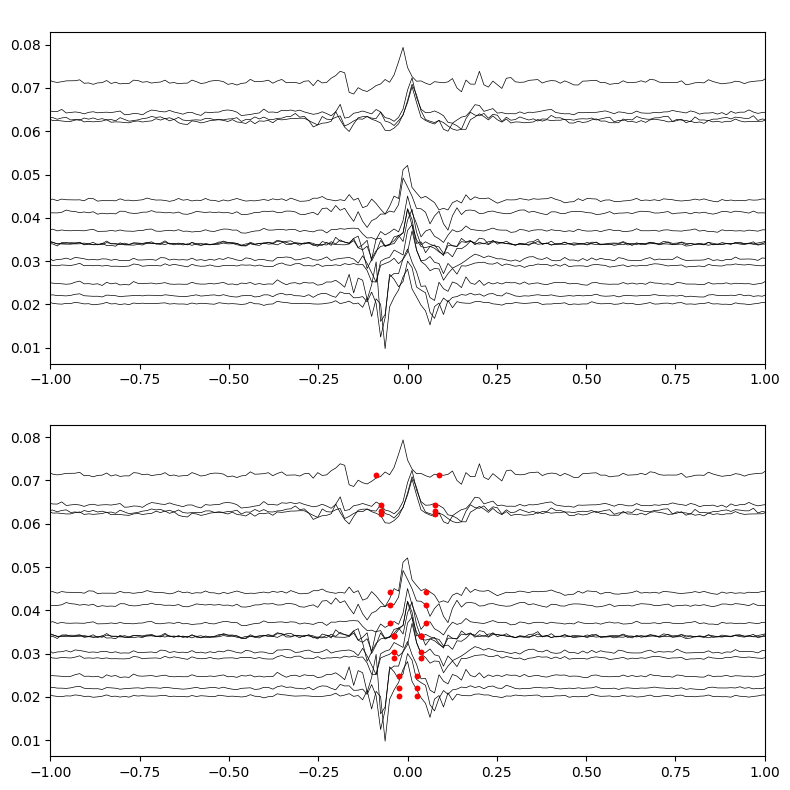

In [12]:
for key_subwork in key_subworks_sample:
    flag_sig = 0
    v_min = 0.8
    v_max = 0.8
    tao = 0.0
    fig,ax = plt.subplots(2,1,figsize = (8,8))
    t,ncfst,info_basic_bi = check_timewindow(info_basic,info_basic_bi,key_subwork,v_min,v_max,tao,ax,start,interval,flag_time,flag_sig,1)